<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab9_mountain_optimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Predictive Control (MPC) for the Mountain Car

## Exercise 1
In this exercise, you will implement **Model Predictive Control (MPC)** using a **random shooting method** to solve the **Mountain Car** problem.

You will complete the `mpc_action()` function, which chooses the best action sequence by simulating multiple random trajectories into the future and selecting the one with the lowest total cost.

---

## ⚙️ Environment Description
You are working with a **simplified Mountain Car** environment, where the goal is to reach and stay near the top of the right hill (`x ≈ 0.45`).

The car’s state is:
- `x` → position  
- `v` → velocity  

The control input is:
- `u` → engine thrust in the range `[-1, 1]`

The dynamics are defined as:
\[
v_{t+1} = v_t + 0.0015 u_t - 0.0025 \cos(3x_t)
\]
\[
x_{t+1} = x_t + v_{t+1}
\]

---

## 🚀 Task
Your task is to **implement mpc_action function for the MPC controller**.

At each step:
1. You will **sample random sequences of actions** for the next `H` steps.
2. You will **simulate** the effect of each sequence on the system using a provided dynamics model.
3. You will **compute the total cost** of each simulated trajectory.
4. You will **choose the best trajectory** (lowest cost) and apply its first action.

---

## ✅ Deliverables
* The completed mpc_action() function.
* A short report (few paragraphs) answering:
    * How does random shooting choose the best action?
    * How does changing H or N_seq affect the result?
    * Did your car reach and stay near the goal?

In [1]:
%matplotlib inline

# Setup environment and collect initial data

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)

### Dynamics
This is the underneath dynamics in the mountain car. For this exercise, we will use it, but for the following sessions, **we will learn it!**

In [4]:
def mountain_car_dynamics(p, v, a):
    v_next = v + 0.001 * a - 0.0025 * np.cos(3 * p)
    v_next = np.clip(v_next, -0.07, 0.07)
    p_next = p + v_next
    if p_next < -1.2:
        p_next, v_next = -1.2, 0.0
    return np.array([p_next, v_next])

# Test dynamics, at position p, and velocity v, predict the new location when the action a=1 is applied.
mountain_car_dynamics(p=-0.5, v=0, a=1.0)

array([-0.49917684,  0.00082316])

### Cost function

In [5]:
def cost_fn(state, a):
    x, v = state
    goal = 0.5
    target = goal - x

    # Encourage moving in the right direction and gaining kinetic energy
    cost = target**2 - 1000 * np.abs(v)
    return cost

## Roll out trajectories based on action sequences U

In [6]:
def roll_out_trajectory(s0, Ui, gamma=1.0):
    s = s0.copy()  # Initial state
    traj = [s0.copy()]  # Trajectory
    H = len(Ui)
    discount = 1.0

    total_cost = 0.0

    # For each time in the planning horizon
    for k in range(H):
        a = Ui[k]  # continuous action in [-1, 1]
        delta_m = np.zeros(2)

        # Predict Δx using both GPs (for Δp, Δv)
        s = mountain_car_dynamics(s[0], s[1], a)
        traj.append(s.copy())

        # Accumulate discounted cost
        total_cost += cost_fn(s, a) * discount
        discount *= gamma
    return np.array(traj), total_cost


def roll_out_n_trajectories(state, U):
    N_seq = len(U)
    J = np.zeros(N_seq)

    # Roll out trajectories and computer their cost
    all_traj = []
    for i in range(N_seq):
        traj, total_cost = roll_out_trajectory(state, U[i])

        J[i] = total_cost
        all_traj.append(np.array(traj))

    return all_traj, J

# Action squence
Ui = np.zeros(3)
traj, J = roll_out_trajectory(np.array([-0.5,0]), Ui)
traj

array([[-5.00000000e-01,  0.00000000e+00],
       [-5.00176843e-01, -1.76843004e-04],
       [-5.00529206e-01, -3.52362983e-04],
       [-5.01054453e-01, -5.25246664e-04]])

In [7]:
def plot_trajectories(state, best_traj):
    plt.figure(figsize=(8, 6))
    for i, traj in enumerate(best_traj):
        plt.plot(traj[:, 0], traj[:, 1], lw=2, alpha=0.8, label=f"Traj {i+1}")
    plt.scatter(state[0], state[1], color='red', s=60, label="Start", zorder=5)
    plt.axvline(0.5, color='gray', ls='--', label='Goal position')
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title(f"Predicted Trajectories (Continuous MPC)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Finding optimal action for MPC (Random Shooting)

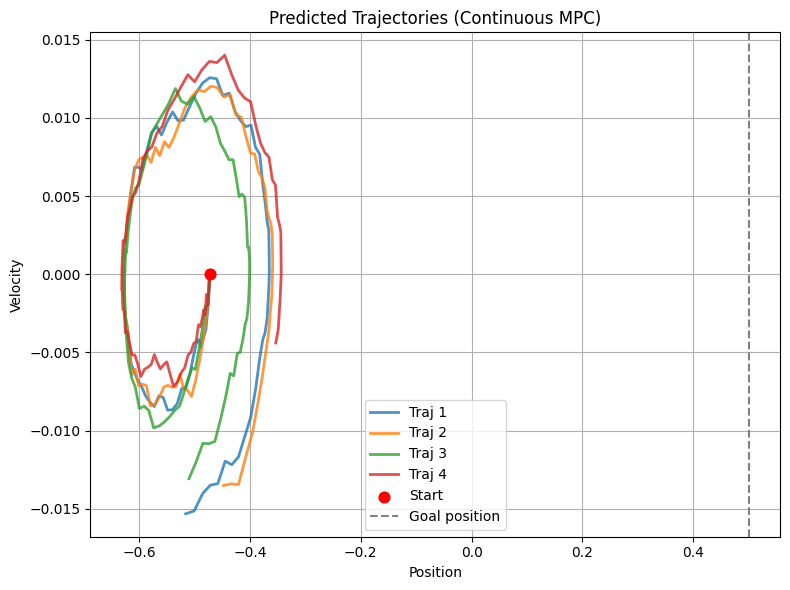

In [10]:
def mpc_action(state, H=25, N_seq=200, plot=False, plot_best=10, repeat=1):
    """
    Random Shooting MPC for the continuous Mountain Car environment.

    Args:
        state       : np.array([position, velocity])
        H           : planning horizon
        N_seq       : number of sampled action sequences
        plot        : whether to visualize predicted trajectories
        plot_best   : number of best trajectories to visualize
        repeat      : number of steps to repeat the same action
                      (reduces search complexity and produces smoother actions)

    Returns:
        best_action : the first action of the selected optimal sequence
    """

    state = np.asarray(state, dtype=float)


    # 1) Sample random action sequences in [-1, 1]
    #    If repeat > 1, each action is held constant for several steps
    if repeat > 1:
        H_blocks = int(np.ceil(H / repeat))
        U_blocks = np.random.uniform(-1.0, 1.0, size=(N_seq, H_blocks))
        U = np.repeat(U_blocks, repeats=repeat, axis=1)[:, :H]
    else:
        U = np.random.uniform(-1.0, 1.0, size=(N_seq, H))

    # 2) Roll out trajectories using the known dynamics model
    all_traj, J = roll_out_n_trajectories(state, U)

    # 3) Select the sequence with the lowest cost
    order = np.argsort(J)                    # lower cost is better
    best_indices = order[:max(1, plot_best)]
    best_sequence = U[order[0]]
    best_action = float(np.clip(best_sequence[0], -1.0, 1.0))

    # 4) Optional: visualize the best predicted trajectories
    if plot:
        best_traj = [all_traj[i] for i in best_indices]
        plot_trajectories(state, best_traj)

    return best_action

obs, _ = env.reset(seed=0)
a = mpc_action(obs, H=80, N_seq=100, plot=True, plot_best=4)


In [12]:
# --------------------------------------------------------------
# Running in the gym environment
# --------------------------------------------------------------
H = 80        # MPC horizon
N_seq = 200   # Number of sampled action sequences
steps = 500   # Max episode length


obs, _ = env.reset()
returns = 0.0
a = 0.0       # initial action

trajectory = []

for t in range(steps):
    # --- 1. Compute optimal action via MPC ---
    a = mpc_action(obs, H=H, N_seq=N_seq)

    if t%10==0:
        print("t=",t, "state=", obs, "a=",a)

    # --- 2. Step environment ---
    next_obs, r, term, trunc, _ = env.step([a])  # continuous env expects array-like
    trajectory.append([obs,a])
    env.render()  # draw each step

    returns += r

    # --- 5. Prepare next step ---
    obs = next_obs
    if term or trunc:
        break

print(f"Episode return: {returns:.2f}")
env.close()


t= 0 state= [-0.5918053  0.       ] a= 0.31777633260434435
t= 10 state= [-0.54945904  0.00888711] a= -0.22945255672652842
t= 20 state= [-0.42053136  0.01523984] a= 0.6387014490068346
t= 30 state= [-0.291659    0.00716537] a= -0.6895673623146044
t= 40 state= [-0.33463582 -0.01388613] a= -0.9787118893511517
t= 50 state= [-0.5564812  -0.02742948] a= -0.19846838217612284
t= 60 state= [-0.8318165  -0.02374794] a= -0.13971911505697343
t= 70 state= [-0.96557957 -0.00530245] a= 0.6596152427883648
t= 80 state= [-0.88763833  0.0180958 ] a= 0.49452268226550755
t= 90 state= [-0.5901646   0.03727897] a= 0.9640868115749175
t= 100 state= [-0.17831382  0.03810479] a= -0.8339107577341807
t= 110 state= [0.0471483  0.01157039] a= -0.038221649892999476
t= 120 state= [ 0.03972335 -0.012325  ] a= 0.6403719750357706
t= 130 state= [-0.20269482 -0.03567638] a= -0.7980423598825088
t= 140 state= [-0.6604525  -0.04894082] a= -0.5045685853294697
t= 150 state= [-1.0830674  -0.03279524] a= -0.6047907636269132
t= 160

In [14]:
# trajectory is a list of [obs, a]
# each obs is [pos, vel]
def plot_trajectory(trajectory, step=5):
    positions, velocities, actions = [], [], []

    for i, entry in enumerate(trajectory):
        if i % step != 0:
            continue
        obs, a = entry
        positions.append(obs[0])
        velocities.append(obs[1])
        actions.append(float(a))

    positions = np.array(positions)
    velocities = np.array(velocities)
    actions = np.array(actions)

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(positions, velocities, c=actions,
                     cmap='coolwarm', s=40, edgecolor='k', alpha=0.8)

    plt.colorbar(sc, label="Action (acceleration)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("MountainCar Trajectory (sampled points)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


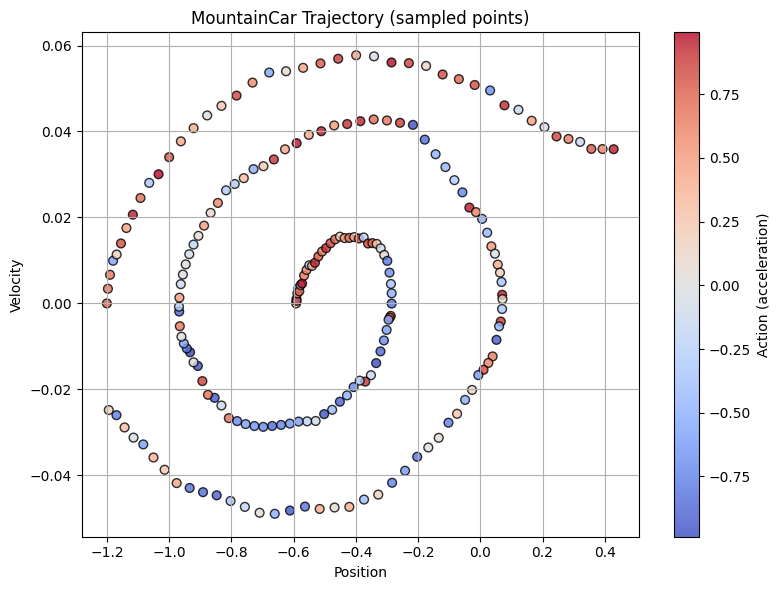

In [17]:
plot_trajectory(trajectory, step=1)

[Diagnostic] top-4 sequence indices: [121, 166, 171, 33]
[Diagnostic] best cost = -868.902, best first action = -0.982


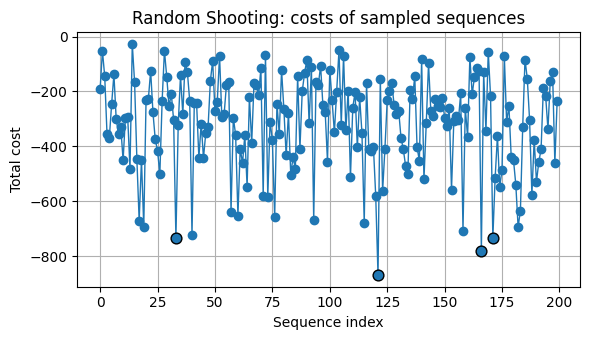

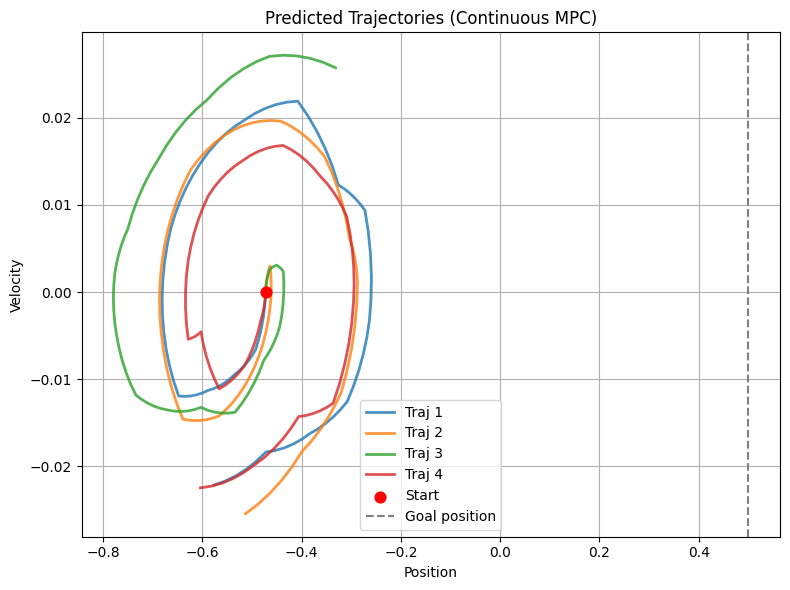

In [19]:
# --- Step diagnostic for "how random shooting picks the best action" ---

def random_shooting_diagnostic(state, H=80, N_seq=200, repeat=5, topk=5):
    # sample candidate sequences exactly as MPC does
    if repeat > 1:
        H_blocks = int(np.ceil(H / repeat))
        U_blocks = np.random.uniform(-1.0, 1.0, size=(N_seq, H_blocks))
        U = np.repeat(U_blocks, repeats=repeat, axis=1)[:, :H]
    else:
        U = np.random.uniform(-1.0, 1.0, size=(N_seq, H))

    # rollout & compute costs
    all_traj, J = roll_out_n_trajectories(np.asarray(state, float), U)

    order = np.argsort(J)
    best_idx = order[:topk]
    best_seq  = U[order[0]]
    best_cost = J[order[0]]
    best_a0   = float(np.clip(best_seq[0], -1, 1))

    print(f"[Diagnostic] top-{topk} sequence indices:", best_idx.tolist())
    print(f"[Diagnostic] best cost = {best_cost:.3f}, best first action = {best_a0:.3f}")

    # simple cost plot
    plt.figure(figsize=(6,3.5))
    plt.plot(J, marker='o', lw=1)
    plt.scatter(best_idx, J[best_idx], s=60, edgecolors='k', zorder=5)
    plt.xlabel("Sequence index"); plt.ylabel("Total cost")
    plt.title("Random Shooting: costs of sampled sequences")
    plt.grid(True); plt.tight_layout(); plt.show()

    # (Optional) plot the top-k predicted trajectories
    best_traj = [all_traj[i] for i in best_idx]
    plot_trajectories(state, best_traj)

    return best_a0, best_cost, best_idx, U, J

# Example usage at the start state:
obs, _ = env.reset(seed=0)
_ = random_shooting_diagnostic(obs, H=80, N_seq=200, repeat=5, topk=4)


#  Impact of H or N_seq

In [23]:

def run_mpc_episode(H=80, N_seq=200, repeat=5, steps=500, goal_x=0.45):
    """
    Run one episode with MPC and report:
      - total return,
      - whether the goal was reached.
    Note: MountainCarContinuous-v0 terminates immediately on goal, so "stayed"
    is not applicable (returned as None).
    """
    obs, _ = env.reset()
    total_ret = 0.0
    positions = []

    reached = False

    for _ in range(steps):
        a = mpc_action(obs, H=H, N_seq=N_seq, plot=False, repeat=repeat)
        next_obs, r, term, trunc, _ = env.step([a])

        # record current state's position
        positions.append(float(obs[0]))
        total_ret += r

        # advance state
        obs = next_obs

        if term or trunc:
            # include terminal state's position (next_obs)
            positions.append(float(obs[0]))
            # in this env, term=True iff goal reached
            reached = term or (obs[0] >= goal_x)
            break

    stayed = None  # environment ends at goal; staying is N/A
    return total_ret, reached, stayed


# expanded grid
settings = [
    (5,   50),
    (10,  50),
    (20,  50),
    (40,  50),
    (80,  50),
    (120, 50),

    (40,  10),
    (40,  20),
    (40,  50),
    (40, 100),
    (40, 200),
    (40, 500),

    # best baseline + worst baseline
    (80, 200),
    (10, 10)
]


print("| H | N_seq | Return | Reached | Stayed |")
print("|---|-------|--------|---------|--------|")
for H, N in settings:
    ret, reached, stayed = run_mpc_episode(H=H, N_seq=N, repeat=5)
    print(f"| {H} | {N} | {ret:6.2f} | {str(reached):>7} | {str(stayed):>6} |")


| H | N_seq | Return | Reached | Stayed |
|---|-------|--------|---------|--------|
| 5 | 50 |  93.11 |    True |   None |
| 10 | 50 |  92.53 |    True |   None |
| 20 | 50 |  94.77 |    True |   None |
| 40 | 50 |  94.40 |    True |   None |
| 80 | 50 |  94.07 |    True |   None |
| 120 | 50 |  92.75 |    True |   None |
| 40 | 10 |  90.99 |    True |   None |
| 40 | 20 |  93.01 |    True |   None |
| 40 | 50 |  93.49 |    True |   None |
| 40 | 100 |  93.22 |    True |   None |
| 40 | 200 |  94.04 |    True |   None |
| 40 | 500 |  93.82 |    True |   None |
| 80 | 200 |  93.68 |    True |   None |
| 10 | 10 |  95.09 |    True |   None |


In [24]:
import time

def run_mpc_episode_metrics(H=80, N_seq=200, repeat=5, steps=500, goal_x=0.45):
    obs, _ = env.reset()
    total_ret = 0.0
    positions = []
    step_times = []

    reached = False
    steps_to_goal = None

    for t in range(steps):
        t0 = time.time()
        a = mpc_action(obs, H=H, N_seq=N_seq, plot=False, repeat=repeat)
        step_times.append((time.time() - t0) * 1000.0)  # ms

        next_obs, r, term, trunc, _ = env.step([a])
        positions.append(float(obs[0]))
        total_ret += r
        obs = next_obs

        if term or trunc:
            positions.append(float(obs[0]))  # include terminal state
            reached = term or (obs[0] >= goal_x)
            if reached:
                steps_to_goal = t + 1
            break

    max_x = float(np.max(positions)) if positions else -1.2
    avg_ms_per_step = float(np.mean(step_times)) if step_times else 0.0
    return {
        "return": total_ret,
        "reached": reached,
        "steps_to_goal": steps_to_goal,
        "max_x": max_x,
        "avg_ms_per_step": avg_ms_per_step,
    }


In [25]:
H_list = [5, 10, 20, 40, 80, 120]
N_list = [5, 10, 20, 50, 100, 200]
repeat = 1   # harder than 5; will show differences

print("| H | N_seq | Success | Steps | Max x  | Avg ms/step | Return |")
print("|---|-------|---------|-------|--------|-------------|--------|")

for H in H_list:
    for N in N_list:
        m = run_mpc_episode_metrics(H=H, N_seq=N, repeat=repeat)
        succ = "T" if m["reached"] else "F"
        steps = "-" if m["steps_to_goal"] is None else m["steps_to_goal"]
        print(f"| {H:3d} | {N:5d} | {succ:^7} | {steps!s:>5} | {m['max_x']:6.2f} | {m['avg_ms_per_step']:11.1f} | {m['return']:6.2f} |")


| H | N_seq | Success | Steps | Max x  | Avg ms/step | Return |
|---|-------|---------|-------|--------|-------------|--------|
|   5 |     5 |    T    |   145 |   0.47 |         0.5 |  94.35 |
|   5 |    10 |    T    |   113 |   0.45 |         0.8 |  95.02 |
|   5 |    20 |    T    |    83 |   0.46 |         1.5 |  95.80 |
|   5 |    50 |    T    |    77 |   0.48 |         3.6 |  95.27 |
|   5 |   100 |    T    |    77 |   0.47 |         7.1 |  95.02 |
|   5 |   200 |    T    |    75 |   0.45 |        15.4 |  95.02 |
|  10 |     5 |    T    |   248 |   0.47 |         0.8 |  90.96 |
|  10 |    10 |    T    |   154 |   0.46 |         1.4 |  94.03 |
|  10 |    20 |    T    |   115 |   0.45 |         2.8 |  95.02 |
|  10 |    50 |    T    |   145 |   0.50 |         6.8 |  93.00 |
|  10 |   100 |    T    |   142 |   0.50 |        13.7 |  93.00 |
|  10 |   200 |    T    |   108 |   0.47 |        36.9 |  94.38 |
|  20 |     5 |    T    |   333 |   0.45 |         1.4 |  88.20 |
|  20 |    10 

# 🧩 Exercise 2: Implement the MPPI Controller

In this exercise, you will complete the **`action()` method** of the `MPPIController` class.  
This method implements the **Model Predictive Path Integral (MPPI)** algorithm, which selects an optimal control action based on sampled action sequences and their simulated costs.

---

## ⚙️ MPPI Overview

Model Predictive Path Integral (MPPI) control is a **sampling-based model predictive controller**.  
It explores many possible future action sequences and evaluates them under a dynamics model.  
Unlike random shooting, MPPI adds **Gaussian noise around a mean sequence** and keeps track of a **persistent best sequence** that shifts at every step.

At each time step:

1. **Shift** the previous mean action sequence (`U_mean`) forward in time.  
   → This reuses information from the last solution.

2. **Sample** new action sequences by adding Gaussian noise around this mean.

3. **Roll out** each sequence using the system dynamics to compute its total cost.

4. Mean computation:
   * For undergraduate: **Select** the best trajectory (the one with the lowest cost) as the mean. (MPPI Simplified version)
   * For graduate: Compute **importance-weighted averages of control perturbations**, following the path-integral formulation of stochastic optimal control.

6. **Return** the first action of the best sequence to apply to the system.

---
# 🧩 Deliverables

* The completed action() method implementation.

* A short explanation (1–2 paragraphs) describing how your controller selects actions and how it differs from random shooting.

* Questions for Discussion

    * Why does MPPI reuse the previous mean sequence (U_mean)?

    * What would happen if we didn’t shift it each iteration?

    * How does the horizon H affect stability and responsiveness?

    * Compare MPPI to random shooting — what advantage does MPPI bring?


# MPPI

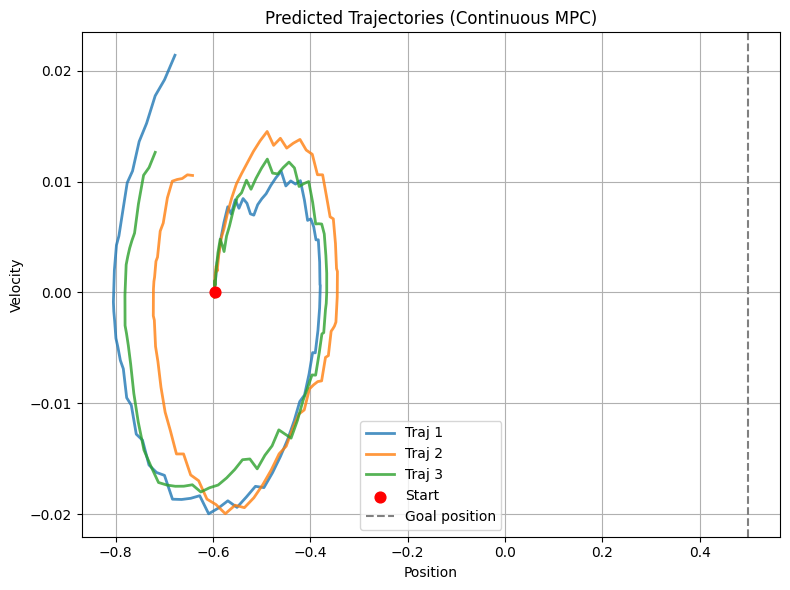

0.45158451485475387

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MPPIController:
    def __init__(self, H=100, N_seq=200, λ=1.0, σ=0.3):
        """
        Model Predictive Path Integral Controller with persistent action sequence.
        Uses the best trajectory (lowest-cost) to update instead of weighted mean.
        """
        self.H = H
        self.N_seq = N_seq
        self.λ = λ
        self.σ = σ


        # Persistent mean sequence for warm-start
        self.U_mean = np.zeros(H)

    def action(self, state, plot=False, plot_best=3):
        H, N_seq, σ = self.H, self.N_seq, self.σ

        ######## TODO #############
        # 0 Shift previous mean sequence (reuse previous solution)

        # 1. Sample action sequences (Gaussian noise around previous U_mean)

        # 2. Roll out trajectories

        # 3. Select the best trajectory (lowest cost)

        #  Optional: plot best trajectories
        if plot:
            best_k = np.argsort(J)[:plot_best]
            best_traj = [all_traj[i] for i in best_k]
            plot_trajectories(state, best_traj)

        # 4. Return the first action of the best sequence
        best_action = ????
        return best_action

# Initialize controller once
mppi = MPPIController(H=80, N_seq=150, λ=1.0, σ=2.1)

obs, _ = env.reset()
a = mppi.action(obs, plot=True, plot_best=3)  # plot first iteration only
a

In [ ]:
# Initialize controller once
mppi = MPPIController(H=30, N_seq=200, λ=.10, σ=.50)

obs, _ = env.reset(seed=0)
traj = []

for t in range(500):
    a = mppi.action(obs)  # plot first iteration only
    traj.append([obs, a])

    if t%10==0:
      print(t, obs, a)

    obs, r, term, trunc, _ = env.step([a])


    if term or trunc:
        break

print(f"Total time: {t:.0f}")


0 [-0.47260767  0.        ] -0.19541412486037116
10 [-0.53274834 -0.01213859] -1.0
20 [-0.71013486 -0.01957657] -1.0
30 [-0.84511495 -0.00350365] 1.0
40 [-0.6939198   0.02908103] 0.4319585596382203
50 [-0.30572042  0.04320084] 0.9751332542541268
60 [0.09553665 0.03597105] 0.8678720273360755
70 [0.41994184 0.03231012] 1.0
Total time: 70


<>:3: SyntaxWarning: invalid decimal literal
<>:3: SyntaxWarning: invalid decimal literal
/tmp/ipython-input-1621329264.py:3: SyntaxWarning: invalid decimal literal
  print("Energy", sum([a**2for s,a in traj]))


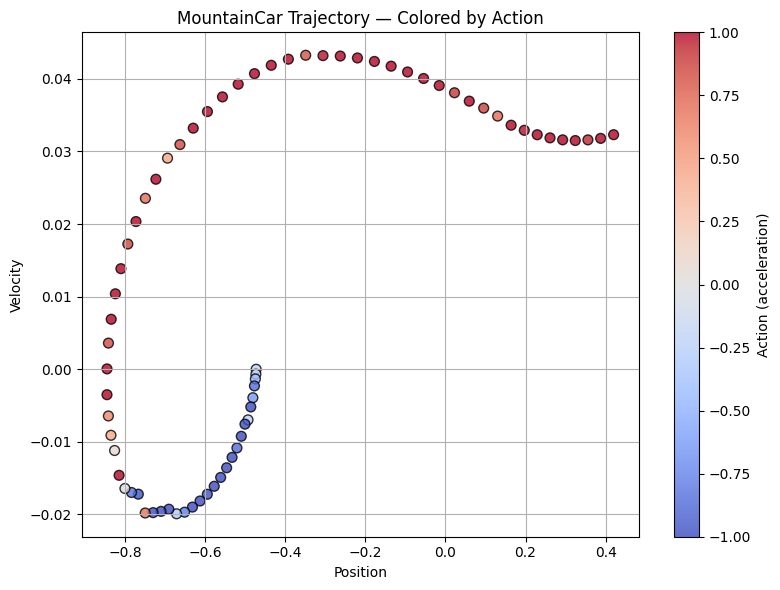

Energy 56.60869591532342


In [ ]:
plot_trajectory(traj)

print("Energy", sum([a**2for s,a in traj]))

# 🧩 Exercise 3: Reward Engineering — Stop at the Goal and Save Energy

In this exercise you will explore **reward shaping** and how it changes robot behavior.  
You will modify the Mountain Car reward so that the robot:
1. **Stops at the goal** rather than overshooting it.  
2. **Uses minimal control effort** (energy efficiency).

The goal is to understand how each term in a reward function influences motion and stability.

---

## ⚙️ Background
In reinforcement learning and model-based control, the reward (or cost) encodes *what* we want the agent to do.  
A poorly designed reward may lead to:
- Unstable or oscillatory behavior  
- Excessive control effort  
- Agents that reach the goal but never stop  

The standard Mountain Car reward only gives a terminal bonus for reaching the goal:
\[
r = 100 \, \mathbf{1}[x \ge 0.45] - 0.1u^2
\]
It encourages reaching the hilltop but does **not** reward *staying there* or *saving energy*.

---

## 🧩 Tasks

### a) Make the robot **stop at the goal**
You will modify the reward so that the agent receives high reward when it is **close to the goal** *and* has **small velocity**.

Implement a new reward function that encourages being near the goal position, and make the car stop once it arrives.  


Test this reward inside your MPC or MPPI loop.  
Observe whether the car reaches the top and remains there.

---

### b) Make the robot **save energy**
Design a second version of the reward that explicitly penalizes energy use more strongly. The energy is proportional to the square of the control input **a**.


Run simulations again and compare:
- Does the car reach the goal more slowly?  
- Does it stop more gently?  
- How much smaller are the average control inputs?

---

## Hint
Take into account that the weights help to scale the magnitude of the variables. For example,

---
# ✅ Deliverables

* Two implemented reward functions:

    * (a) Stop-at-goal

    * (b) Energy-saving

* Position, velocity, and control plots for both cases.

* A short report (≈ 1 paragraph per reward) answering:

    * How did each reward affect the trajectory?

    * Which terms were most influential?

    * Did the car stop smoothly at the goal?
